In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn import preprocessing
import pyodbc
import pickle
import math
import time
import warnings
import os
import sys

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
sys.setrecursionlimit(10000)

In [2]:
#Loading the data from model table in SQL Server

sql_conn = pyodbc.connect("DSN=CNPPEDW05")

# sql = "select * from [Analytics_RPT].[dbo].[DTC_SBR_PortfolioLoanSegmentData]"
sql = "select * from Analytics_RPT.dbo.DTC_SBR_PortfolioLoanSegment_Training_Data"

df = pd.read_sql(sql, sql_conn)

df.shape

(2355939, 63)

In [3]:
original_features_prop = ['loan_num_srvcr',
 'AsOfDt',
 'OrigLoanRefiPurpose',
 'lien_position',
 'term_orig',
 'term_remaining',
 'HomePriceAppreciation',
 'CurrentPIPmt',
 'CurrRate',
 'orig_LTV',
 'Val_waterfall',
 'PropState',
 'OccType',
 'PropType',
 'VintageYear',
 'bal_orig',
 'borrw_mail_state',
 'prop_yr_blt',
 'HomeEquityAmt',
 'BenefitFlag_Prev_90_days',
 'BenefitCategory_Prev_90_days',
 'cd_bill_meth',
 'OrigChannel',
 'prop_NumberOfUnits',
 'LandSquarefeet',
 'LandValue',
 'IsNewConstruction',
 'IsPropertyInspectionWaived',
 'IsSpecOrModelHome',
 'NumberOfFinancedProperties',
 'Delq30In6',
 'Delq30In12',
 'Delq30In24',
 'Delq60In6',
 'Delq60In12',
 'Delq60In24',
 'OrigLoanPurpose',
 'OrigLoanDocType',
 'CombinedMonthlyIncomeH2O',
 'AccountAssetsH2O',
 'OtherAssetsH2O',
 'OrigLoanDTI',
 'TotalNetWorth',
 'NumberOfBathrooms',
 'NumberOfBedrooms',
 'eng_UPB',
 'eng_diff_curr_orig_prevailing_pmt',           
 'eng_diff_asofdt_origdt_prevailing_rate',           
 'eng_orig_years']

In [4]:
num_cols_prop = ['term_orig',
 'term_remaining',
 'HomePriceAppreciation',
 'CurrentPIPmt',
 'CurrRate',
 'orig_LTV',
 'Val_waterfall',
 'bal_orig',
 'prop_yr_blt',
 'HomeEquityAmt',
 'LandSquarefeet',
 'LandValue',
 'NumberOfFinancedProperties',
 'Delq30In6',
 'Delq30In12',
 'Delq30In24',
 'Delq60In6',
 'Delq60In12',
 'Delq60In24',
 'CombinedMonthlyIncomeH2O',
 'AccountAssetsH2O',
 'OtherAssetsH2O',
 'OrigLoanDTI',
 'TotalNetWorth',
 'VintageYear',
 'NumberOfBedrooms',
 'NumberOfBathrooms',            
 'eng_UPB',
 'eng_diff_curr_orig_prevailing_pmt',           
 'eng_diff_asofdt_origdt_prevailing_rate']

In [5]:
cat_cols_prop = ['lien_position',
 'OrigChannel',
 'OrigLoanRefiPurpose',
 'BenefitFlag_Prev_90_days',
 'BenefitCategory_Prev_90_days',
 'cd_bill_meth',
 'IsPropertyInspectionWaived',
 'IsSpecOrModelHome',
 'PropType',
 'OrigLoanPurpose',
 'IsNewConstruction',
 'OccType',
 'OrigLoanDocType',
 'PropState',
 'borrw_mail_state',
 'prop_NumberOfUnits',
 'eng_orig_years']

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
class prop_coalesce(BaseEstimator, TransformerMixin):
    
    def __init__(self,YearBuilt,Year_Built,prop_yr_blt,inf_NumberOfBathrooms,serv_NumberOfBathrooms,serv_NumberOfBedrooms,inf_NumberOfBedrooms,LandSquarefeet,Land_Squarefeet,prop_NumberOfUnits):
        self.YearBuilt = YearBuilt
        self.Year_Built = Year_Built
        self.prop_yr_blt = prop_yr_blt
        self.inf_NumberOfBathrooms = inf_NumberOfBathrooms
        self.serv_NumberOfBathrooms = serv_NumberOfBathrooms
        self.serv_NumberOfBedrooms = serv_NumberOfBedrooms
        self.inf_NumberOfBedrooms = inf_NumberOfBedrooms
        self.LandSquarefeet = LandSquarefeet
        self.Land_Squarefeet = Land_Squarefeet
        self.prop_NumberOfUnits = prop_NumberOfUnits
        self.prop_dict = {1:'one',2:'two',3:'three',4:'four'}
        
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X = X.copy()
        
        X[self.prop_NumberOfUnits] = X[self.prop_NumberOfUnits].apply(lambda x: self.prop_dict.get(x))
        # Coalesce for YearBuilt
        X.loc[X[self.YearBuilt].isnull(),self.YearBuilt] = X.loc[X[self.YearBuilt].isnull(),self.Year_Built]
        X.loc[X[self.prop_yr_blt].isnull(),self.prop_yr_blt] = X.loc[X[self.prop_yr_blt].isnull(),self.YearBuilt]
        
        # Coalesce for Number of Bathrooms
        X[self.inf_NumberOfBathrooms] = X[self.inf_NumberOfBathrooms].astype('float64')
        X[self.inf_NumberOfBathrooms] = X[self.inf_NumberOfBathrooms].apply(lambda x:x/100 if x%100 == 0 else x)
        X['NumberOfBathrooms'] = X[self.serv_NumberOfBathrooms]
        X.loc[X['NumberOfBathrooms'].isnull(),'NumberOfBathrooms'] = X.loc[X['NumberOfBathrooms'].isnull(),self.inf_NumberOfBathrooms]
        
        # Coalesce for Number of Bedrooms
        X['NumberOfBedrooms'] = X[self.serv_NumberOfBedrooms]
        X.loc[X['NumberOfBedrooms'].isnull(),'NumberOfBedrooms'] = X.loc[X['NumberOfBedrooms'].isnull(),self.inf_NumberOfBedrooms]
        X.loc[X[self.LandSquarefeet].isnull(),self.LandSquarefeet] = X.loc[X[self.LandSquarefeet].isnull(),self.Land_Squarefeet]
        
        X.drop([self.YearBuilt,self.Year_Built,self.serv_NumberOfBathrooms,self.inf_NumberOfBathrooms,self.serv_NumberOfBedrooms,self.inf_NumberOfBedrooms,self.Land_Squarefeet],axis=1,inplace=True)
        return X

In [7]:
#calculate the PIPmt
# p = principal
# i = interest
# t = term
def PIpmt(p,i,t):
    i = i/1200
    n = int(t)
    if i!=0:
        return (p*i*pow(i+1,n))/(pow(i+1,n)-1)
    else:
        return 0

In [8]:
def year_fun(x):
    if np.floor(x/365)< 1:
        return '< 1'
    elif np.floor(x/365) < 3:
        return '1-3 yrs'
    elif np.floor(x/365) < 6:
        return '3-5 yrs'
    else:
        return '5+'

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
class prop_feature_additions(BaseEstimator, TransformerMixin):
    
    def __init__(self,prevailing_rate_curr,prevailing_rate_orig,Val_waterfall,HomeEquityAmt,bal_orig,term_orig,AsOfDt,orig_dt):
        self.prevailing_rate_curr = prevailing_rate_curr
        self.prevailing_rate_orig = prevailing_rate_orig
        self.Val_waterfall = Val_waterfall
        self.HomeEquityAmt = HomeEquityAmt
        self.bal_orig = bal_orig
        self.term_orig = term_orig
        self.AsOfDt = AsOfDt
        self.orig_dt = orig_dt
        
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X = X.copy()
        X['eng_orig_years'] = ((pd.to_datetime(X[self.AsOfDt]) - pd.to_datetime(X[self.orig_dt])).dt.days).apply(year_fun)
        X['eng_UPB'] = X[self.Val_waterfall]-X[self.HomeEquityAmt]
        X['eng_diff_asofdt_origdt_prevailing_rate'] = X[self.prevailing_rate_curr] - X[self.prevailing_rate_orig]
        X['eng_CurrPIPmt'] = X.apply(lambda x: PIpmt(x['eng_UPB'],x[self.prevailing_rate_curr],x[self.term_orig]),axis=1)
        X['eng_pastPIpmt'] = X.apply(lambda x: PIpmt(x[self.bal_orig],x[self.prevailing_rate_orig],x[self.term_orig]),axis=1)
        X['eng_diff_curr_orig_prevailing_pmt'] = X['eng_CurrPIPmt']-X['eng_pastPIpmt']
        return X

In [10]:
#class to get required columns only
from sklearn.base import BaseEstimator, TransformerMixin

class prop_get_needed_columns(BaseEstimator, TransformerMixin):
    
    def __init__(self, original_features):
        self.original_features = original_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        return X[self.original_features]

In [11]:
class prop_ColumnTypeChange_Imputation(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols, cat_cols):
        self.num_cols = num_cols
        self.cat_cols = cat_cols
        
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        X = X.copy()
        X[self.num_cols] = X[self.num_cols].astype('float64')
        X[self.cat_cols] = X[self.cat_cols].apply(lambda x: x.astype(str).str.upper()).astype('object')
        return X

In [12]:
class prop_mean_imputation(BaseEstimator, TransformerMixin):
    
    def __init__(self,mean_impute):
        self.mean_impute = mean_impute
        
    def fit(self, X, y=None):
        self.dict_mean = {}
        for feature in self.mean_impute:
            self.dict_mean[feature] = X[feature].mean()
        return self
    
    def transform(self, X):
        X = X.copy()
        for feature in self.mean_impute:
            X[feature].fillna(self.dict_mean.get(feature),inplace=True)   
        return X

In [13]:
mode_cols_prop = ['lien_position',
'BenefitFlag_Prev_90_days',
'cd_bill_meth',
'IsPropertyInspectionWaived',
'IsSpecOrModelHome',
'PropType',
'IsNewConstruction',
'OccType',
'OrigLoanDocType']

In [14]:
non_mode_cols_prop = ['OrigChannel',
'OrigLoanRefiPurpose',
'BenefitCategory_Prev_90_days',
'OrigLoanPurpose',
'PropState',
'borrw_mail_state',
'prop_NumberOfUnits']

In [15]:
class prop_cat_imputation(BaseEstimator, TransformerMixin):
    
    def __init__(self,mode_cols,non_mode_cols):
        self.mode_cols = mode_cols
        self.non_mode_cols = non_mode_cols
        
    def fit(self, X, y=None):
        self.dict_mode = {}
        for feature in self.mode_cols:
            self.dict_mode[feature] = X[feature].mode()[0]
        return self
    
    def transform(self, X):
        X = X.copy()
        for feature in self.mode_cols:
            X[feature] = X[feature].replace(np.nan,self.dict_mode.get(feature))

        for feature in self.non_mode_cols:
            X[feature] = X[feature].replace(np.nan,'UNKNOWN')
            
        return X

In [16]:
from sklearn.preprocessing import StandardScaler
class prop_standardize(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols):
        self.num_cols = num_cols
        
        
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.num_cols:
            self.scaler.fit(np.array(X[col]).reshape(-1,1))
            X[col] = self.scaler.transform(np.array(X[col]).reshape(-1,1))  
        return X

In [17]:
def calc_smooth_mean(df, by, on, m):
    mean = df[on].mean()
    agg = df.groupby(by)[on].agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts*means+m*mean)/(counts+m)
    return smooth

In [18]:
class prop_target_encoding(BaseEstimator, TransformerMixin):
    
    def __init__(self,cat_cols):
        self.cat_cols = cat_cols
        
    def fit(self, X, y):
        X['refi_flag'] = y
        self.dict_target = {}
        for feature in self.cat_cols:
            self.dict_target[feature] = calc_smooth_mean(X,feature,'refi_flag',1000)
        return self
    
    def transform(self, X):
        X= X.copy()
        for feature in self.cat_cols:
            X[feature] = X[feature].map(self.dict_target.get(feature)*100)
        return X

In [19]:
from sklearn.pipeline import Pipeline
Propensity_preprocess_pipe = Pipeline([('coalesce',prop_coalesce('YearBuilt','Year Built','prop_yr_blt','inf_NumberOfBathrooms','serv_NumberOfBathrooms','serv_NumberOfBedrooms','inf_NumberOfBedrooms','LandSquarefeet','Land Squarefeet','prop_NumberOfUnits')),
('feature_engineering',prop_feature_additions('prevailing_rate_curr','prevailing_rate_orig','Val_waterfall','HomeEquityAmt','bal_orig','term_orig','AsOfDt','orig_dt')),                
('get_cols', prop_get_needed_columns(original_features_prop)),
('columntype_change', prop_ColumnTypeChange_Imputation(num_cols_prop,cat_cols_prop)),
('num_imputation', prop_mean_imputation(num_cols_prop)),
('cat_imputation', prop_cat_imputation(mode_cols_prop, non_mode_cols_prop)),
('standardize_num_cols', prop_standardize(num_cols_prop)),
('target_encode', prop_target_encoding(cat_cols_prop))
])

In [20]:
df.shape

(2355939, 63)

In [21]:
df['AsOfDt'].value_counts()

2020-12-31    306797
2021-01-31    304932
2021-02-28    300319
2021-03-31    294655
2021-04-30    288150
2021-05-31    288087
2021-06-30    286744
2021-07-31    286255
Name: AsOfDt, dtype: int64

In [22]:
import datetime
df[df['AsOfDt'] <= datetime.date(2021,6,30)]['AsOfDt'].value_counts()

2020-12-31    306797
2021-01-31    304932
2021-02-28    300319
2021-03-31    294655
2021-04-30    288150
2021-05-31    288087
2021-06-30    286744
Name: AsOfDt, dtype: int64

In [23]:
df_train_propensity = df[df['AsOfDt'] <= datetime.date(2021,6,30)]

In [24]:
df_test_propensity = df[df['AsOfDt'] == datetime.date(2021,7,31)]

In [25]:
df_copy = df_train_propensity.copy(deep=True)
processed_df = Propensity_preprocess_pipe.fit_transform(df_copy,df_copy['refi_flag'])
processed_df.shape

(2069684, 50)

In [26]:
processed_df.head()

,loan_num_srvcr,AsOfDt,OrigLoanRefiPurpose,lien_position,term_orig,term_remaining,HomePriceAppreciation,CurrentPIPmt,CurrRate,orig_LTV,Val_waterfall,PropState,OccType,PropType,VintageYear,bal_orig,borrw_mail_state,prop_yr_blt,HomeEquityAmt,BenefitFlag_Prev_90_days,BenefitCategory_Prev_90_days,cd_bill_meth,OrigChannel,prop_NumberOfUnits,LandSquarefeet,LandValue,IsNewConstruction,IsPropertyInspectionWaived,IsSpecOrModelHome,NumberOfFinancedProperties,Delq30In6,Delq30In12,Delq30In24,Delq60In6,Delq60In12,Delq60In24,OrigLoanPurpose,OrigLoanDocType,CombinedMonthlyIncomeH2O,AccountAssetsH2O,OtherAssetsH2O,OrigLoanDTI,TotalNetWorth,NumberOfBathrooms,NumberOfBedrooms,eng_UPB,eng_diff_curr_orig_prevailing_pmt,eng_diff_asofdt_origdt_prevailing_rate,eng_orig_years,refi_flag
0,9500008694,2021-05-31,2.071289,2.727764,-1.354465,-3.347467,-0.046897,-0.896526,5.072592,-1.111174,-1.280968,1.975936,2.797884,2.681295,-4.071548,-1.609243,1.967540,-4.199844e-16,-0.568905,2.288236,2.173472,2.837406,2.028755,2.070865,1.632766e-17,4.725047e-17,2.049066,2.070865,2.070865,-5.488713e-17,0.374061,0.416832,0.382092,-0.270474,-0.280937,-0.271105,2.070865,2.070865,-1.175842,-0.015782,-0.008096,-4.856413e-16,-0.056747,4.235538e-16,0.000000,-1.648194,-0.070640,-5.635690,2.136226,0
1,9500008694,2021-03-31,2.071289,2.727764,-1.354465,-3.323402,-0.046897,-0.896526,5.072592,-1.111174,-1.280968,1.975936,2.797884,2.681295,-4.071548,-1.609243,1.967540,-4.199844e-16,-0.571134,2.288236,2.173472,2.837406,2.028755,2.070865,1.632766e-17,4.725047e-17,2.049066,2.070865,2.070865,-5.488713e-17,1.057421,0.416832,0.382092,-0.270474,-0.280937,-0.271105,2.070865,2.070865,-1.175842,-0.015782,-0.008096,-4.856413e-16,-0.056747,4.235538e-16,0.000000,-1.644676,-0.067183,-5.290974,2.136226,0
2,9500008694,2021-01-31,2.071289,2.727764,-1.354465,-3.299337,-0.046897,-0.896526,5.072592,-1.111174,-1.280968,1.975936,2.797884,2.681295,-4.071548,-1.609243,1.967540,-4.199844e-16,-0.573332,2.288236,2.440629,2.837406,2.028755,2.070865,1.632766e-17,4.725047e-17,2.049066,2.070865,2.070865,-5.488713e-17,1.057421,0.788725,0.616904,-0.270474,-0.280937,-0.271105,2.070865,2.070865,-1.175842,-0.015782,-0.008096,-4.856413e-16,-0.056747,4.235538e-16,0.000000,-1.641207,-0.065294,-6.003388,2.136226,0
4,9500009007,2021-03-31,2.071289,2.727764,0.442745,-1.855413,-0.046862,-0.478480,3.639709,-0.031451,-0.851377,2.459831,2.797884,3.086697,-4.071548,-1.053688,2.446755,2.694605e-01,-0.348353,2.288236,2.173472,2.837406,2.028755,2.070865,-1.734371e-02,-2.961952e-02,2.049066,2.070865,2.070865,-5.488713e-17,-0.309298,-0.326953,-0.322344,-0.270474,-0.280937,-0.271105,2.070865,2.070865,0.099672,-0.015782,-0.008096,-4.856413e-16,-0.056747,-9.568531e-02,-0.007437,-1.142426,-0.245298,-3.693789,2.136226,0
5,9500009007,2021-05-31,2.071289,2.727764,0.442745,-1.879479,-0.046862,-0.478480,3.639709,-0.031451,-0.851377,2.459831,2.797884,3.086697,-4.071548,-1.053688,2.446755,2.694605e-01,-0.345647,2.288236,2.173472,2.837406,2.028755,2.070865,-1.734371e-02,-2.961952e-02,2.049066,2.070865,2.070865,-5.488713e-17,-0.309298,-0.326953,-0.322344,-0.270474,-0.280937,-0.271105,2.070865,2.070865,0.099672,-0.015782,-0.008096,-4.856413e-16,-0.056747,-9.568531e-02,-0.007437,-1.146698,-0.261105,-4.038505,2.136226,0


In [27]:
y = processed_df['refi_flag']
total_cols = processed_df.columns.to_list()
total_cols.remove('loan_num_srvcr')
total_cols.remove('AsOfDt')
total_cols.remove('refi_flag')
processed_columns = [l.replace(" ","_") for l in total_cols]
processed_df = processed_df[total_cols]
processed_df.columns = processed_columns
lgbm = LGBMClassifier(n_estimators=2000,
                     metric=  'auc',
                     max_depth= 6,
                     learning_rate= 0.01,
                     min_data_in_leaf= 100,
                     num_leaves= 64,
                     bagging_fraction= 0.8,
                     feature_fraction= 0.8,
                     is_unbalance= True,
                     bagging_freq= 5,
                     bagging_seed= 12345)
lgbm_model = lgbm.fit(processed_df[processed_columns],y) 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [28]:
feature_imp = pd.DataFrame({'Feature':processed_df.columns,'Value':lgbm_model.feature_importances_})
feature_imp = feature_imp.sort_values(by = 'Value',ascending=False)
feature_imp.head(30)

,Feature,Value
3,term_remaining,7086
44,eng_diff_curr_orig_prevailing_pmt,5757
7,orig_LTV,5479
6,CurrRate,5431
45,eng_diff_asofdt_origdt_prevailing_rate,5395
36,CombinedMonthlyIncomeH2O,5345
43,eng_UPB,4655
5,CurrentPIPmt,4084
16,HomeEquityAmt,3995
22,LandSquarefeet,3897


#### pkl file

In [29]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
class prop_lgbm_model(BaseEstimator, TransformerMixin):
    
    def __init__(self,params=None):
        None
        
    def fit(self, X, y):
        self.total_cols = X.columns.to_list()
        self.total_cols.remove('loan_num_srvcr')
        self.total_cols.remove('AsOfDt')
        self.total_cols.remove('refi_flag')
        self.processed_columns = [l.replace(" ","_") for l in self.total_cols]
        X = X[self.total_cols]
        X.columns = self.processed_columns
        lgbm = LGBMClassifier(n_estimators=2000,
                             metric=  'auc',
                             max_depth= 6,
                             learning_rate= 0.01,
                             min_data_in_leaf= 100,
                             num_leaves= 64,
                             bagging_fraction= 0.8,
                             feature_fraction= 0.8,
                             is_unbalance= True,
                             bagging_freq= 5,
                             bagging_seed= 12345)
        self.lgbm_model = lgbm.fit(X[self.processed_columns],y) 
        return self
    
    def transform(self, X):
        
        X = X.copy()
        self.loans = X['loan_num_srvcr']
        self.asofdt = X['AsOfDt']
        X = X[self.total_cols]
        X.columns = self.processed_columns
        probs = self.lgbm_model.predict_proba(X[self.processed_columns])
        probs = [x[1] for x in probs]
        pred_df = pd.DataFrame({'loan_num_srvcr': self.loans,'AsOfDt': self.asofdt,'propensity': probs})
        
        return pred_df


In [30]:
from sklearn.pipeline import Pipeline
Propensity_pipe = Pipeline([('coalesce',prop_coalesce('YearBuilt','Year Built','prop_yr_blt','inf_NumberOfBathrooms','serv_NumberOfBathrooms','serv_NumberOfBedrooms','inf_NumberOfBedrooms','LandSquarefeet','Land Squarefeet','prop_NumberOfUnits')),
('feature_engineering',prop_feature_additions('prevailing_rate_curr','prevailing_rate_orig','Val_waterfall','HomeEquityAmt','bal_orig','term_orig','AsOfDt','orig_dt')),                
('get_cols', prop_get_needed_columns(original_features_prop)),
('columntype_change', prop_ColumnTypeChange_Imputation(num_cols_prop,cat_cols_prop)),
('num_imputation', prop_mean_imputation(num_cols_prop)),
('cat_imputation', prop_cat_imputation(mode_cols_prop, non_mode_cols_prop)),
('standardize_num_cols', prop_standardize(num_cols_prop)),
('target_encode', prop_target_encoding(cat_cols_prop)),
('Model',prop_lgbm_model())])

In [31]:
pipe_fit = Propensity_pipe.fit(df_train_propensity,df_train_propensity['refi_flag'])
pipe_fit

Pipeline(steps=[('coalesce',
                 prop_coalesce(LandSquarefeet='LandSquarefeet',
                               Land_Squarefeet='Land Squarefeet',
                               YearBuilt='YearBuilt', Year_Built='Year Built',
                               inf_NumberOfBathrooms='inf_NumberOfBathrooms',
                               inf_NumberOfBedrooms='inf_NumberOfBedrooms',
                               prop_NumberOfUnits='prop_NumberOfUnits',
                               prop_yr_blt='prop_yr_blt',
                               serv_NumberOfBathrooms='serv_NumberOfBathr...
                 prop_target_encoding(cat_cols=['lien_position', 'OrigChannel',
                                                'OrigLoanRefiPurpose',
                                                'BenefitFlag_Prev_90_days',
                                                'BenefitCategory_Prev_90_days',
                                                'cd_bill_meth',
                              

In [32]:
import pickle
filename = 'Port_call_routing_propensity_V2.pkl'
pickle.dump(pipe_fit, open(filename, 'wb'))

In [33]:
import pickle
filename = 'Port_call_routing_propensity_V2.pkl'
propensity_pipeline = pickle.load(open(filename, 'rb')) 

In [34]:
df_test_propensity.shape

(286255, 63)

In [35]:
df_copy = df_test_propensity.copy(deep=True)

In [45]:
propensity_output = propensity_pipeline.transform(df_copy)
propensity_output.shape

(286255, 3)

In [46]:
propensity_output.head()

,loan_num_srvcr,AsOfDt,propensity
3,9500009007,2021-07-31,0.100572
11,9500011011,2021-07-31,0.005814
17,9500012563,2021-07-31,0.034874
22,9500003562,2021-07-31,0.011982
34,9500005864,2021-07-31,0.045093


In [47]:
propensity_output.dtypes

loan_num_srvcr     object
AsOfDt             object
propensity        float64
dtype: object

In [48]:
df[['loan_num_srvcr','AsOfDt','refi_flag','refi3_flag']].dtypes

loan_num_srvcr    object
AsOfDt            object
refi_flag          int64
refi3_flag         int64
dtype: object

In [49]:
propensity_output = pd.merge(df[['loan_num_srvcr','AsOfDt','refi_flag','refi3_flag']],propensity_output,how='right',on = ['loan_num_srvcr','AsOfDt'])
propensity_output.shape

(286255, 5)

In [50]:
propensity_output.head()

,loan_num_srvcr,AsOfDt,refi_flag,refi3_flag,propensity
0,9500009007,2021-07-31,0,1,0.100572
1,9500011011,2021-07-31,0,0,0.005814
2,9500012563,2021-07-31,0,0,0.034874
3,9500003562,2021-07-31,0,0,0.011982
4,9500005864,2021-07-31,0,0,0.045093


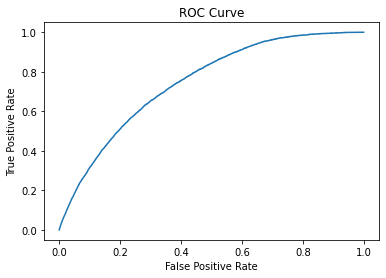

In [51]:
from sklearn.metrics import roc_curve, auc
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(propensity_output['refi_flag'], propensity_output['propensity'])

plt.plot(fpr_lgb, tpr_lgb)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [52]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
roc_auc_score(propensity_output['refi_flag'], propensity_output['propensity'],average='macro')

0.7471522086808401

In [53]:
# Sort on prediction (descending)
propensity_output = propensity_output.sort_values(by = 'propensity',ascending=False)
propensity_output.head()

,loan_num_srvcr,AsOfDt,refi_flag,refi3_flag,propensity
233987,9802219080,2021-07-31,1,1,0.945331
28575,9801820763,2021-07-31,0,1,0.945155
226123,9802084138,2021-07-31,1,1,0.940958
258076,9801552184,2021-07-31,1,1,0.939475
177313,9802012139,2021-07-31,0,0,0.935484


In [54]:
def get_gains(data,target_col):
    
    data['row_id'] = range(0,0+len(data))  # Add row ids
    data['decile'] = ( data['row_id'] / (len(data)/10) ).astype(int) # Add decile
    #data.head()
    
    # Check the count by decile
    data.loc[data['decile'] == 10]=9
    data['decile'].value_counts()
    
    #create gains table
    data['decile'] = data['decile']+1
    gains = data.groupby('decile')[target_col].agg(['count','sum']).reset_index()
    gains.columns = ['decile','count','actual_refis']
    gains
    
    #add metrics to the gains table
    gains['non_actual_refis'] = gains['count'] - gains['actual_refis']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual_refis'].cumsum()
    gains['cum_non_actual'] = gains['non_actual_refis'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual'] ) * 100
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains = pd.DataFrame(gains)
    return gains

In [55]:
# K-S measures the degree of separation between the distributions of the positive and negative responders. 
# If a model cannot separate positive from negative cases, the K-S for all deciles will be 0. 

# If,the lift in Decile 1 is 2.5 it means Decile 1 can get 2.5 times of more locks compared to random selection.

get_gains(propensity_output,'refi_flag')

,decile,count,actual_refis,non_actual_refis,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,K_S,lift
0,1,28626,2048,26578,28626,2048,26578,0.30,0.10,673.2,20.0,3.04
1,2,28625,1309,27316,57251,3357,53894,0.50,0.19,1346.4,31.0,2.49
2,3,28626,967,27659,85877,4324,81553,0.64,0.29,2019.6,35.0,2.14
3,4,28625,712,27913,114502,5036,109466,0.75,0.39,2692.8,36.0,1.87
4,5,28626,597,28029,143128,5633,137495,0.84,0.49,3366.0,35.0,1.67
5,6,28625,479,28146,171753,6112,165641,0.91,0.59,4039.2,32.0,1.51
6,7,28626,354,28272,200379,6466,193913,0.96,0.69,4712.4,27.0,1.37
7,8,28625,162,28463,229004,6628,222376,0.98,0.80,5385.6,18.0,1.23
8,9,28626,74,28552,257630,6702,250928,1.00,0.90,6058.8,10.0,1.11
9,10,28625,30,28595,286255,6732,279523,1.00,1.00,6732.0,0.0,1.00


In [56]:
import scikitplot as skplt
def gain_plot(y,probs):
    
    final_prob_df  = pd.DataFrame({'0': 1-probs,'1':probs})   
    skplt.metrics.plot_cumulative_gain(y,final_prob_df)
    plt.show()

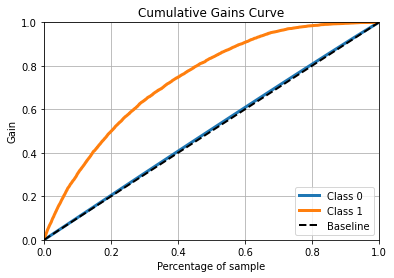

In [57]:
gain_plot(propensity_output['refi_flag'], propensity_output['propensity'])

# K-S measures the degree of separation between the distributions of the positive and negative responders. 
# If a model cannot separate positive from negative cases, the K-S for all deciles will be 0. 

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

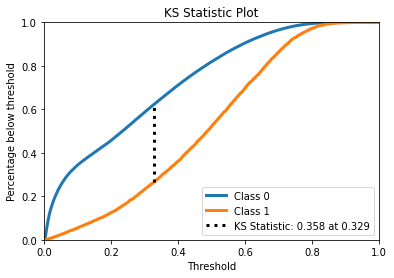

In [58]:
import scikitplot as skplt
probs_lgb_test = propensity_output['propensity']
final_prob_df_test  = pd.DataFrame({'0': 1-probs_lgb_test,'1':probs_lgb_test})
skplt.metrics.plot_ks_statistic(propensity_output['refi_flag'], final_prob_df_test)

In [59]:
## K-S Two Sample Test
# One sample have the prob scores corresponding to non-events and another sample corresponds to events.
from scipy.stats import ks_2samp
ks_2samp(final_prob_df_test['0'], final_prob_df_test['1'],mode='exact')

KstestResult(statistic=0.6238738187979249, pvalue=0.0)

<AxesSubplot:xlabel='refi_flag', ylabel='propensity'>

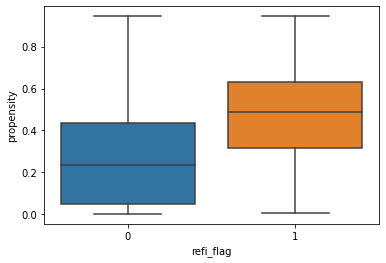

In [60]:
import seaborn as sns
sns.boxplot(y = 'propensity',x = 'refi_flag',data=propensity_output)

In [61]:
propensity_output[propensity_output['refi_flag']==0]['propensity'].mean(),propensity_output[propensity_output['refi_flag']==1]['propensity'].mean()

(0.2654096598683151, 0.46732802761697034)

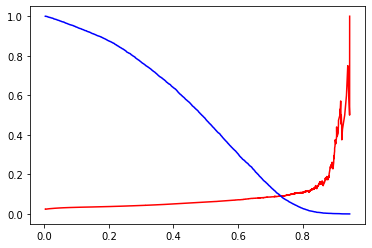

In [62]:
from sklearn.metrics import precision_recall_curve
precision_lgb, recall_lgb, thresholds_lgb = precision_recall_curve(propensity_output['refi_flag'],propensity_output['propensity'])

plt.plot(thresholds_lgb, precision_lgb[:-1], "r-")
plt.plot(thresholds_lgb, recall_lgb[:-1], "b-")
plt.show()